Сгенерируем наши 20 нормально распределенных выборок с равным средним и дисперсией.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests

random.seed(6)

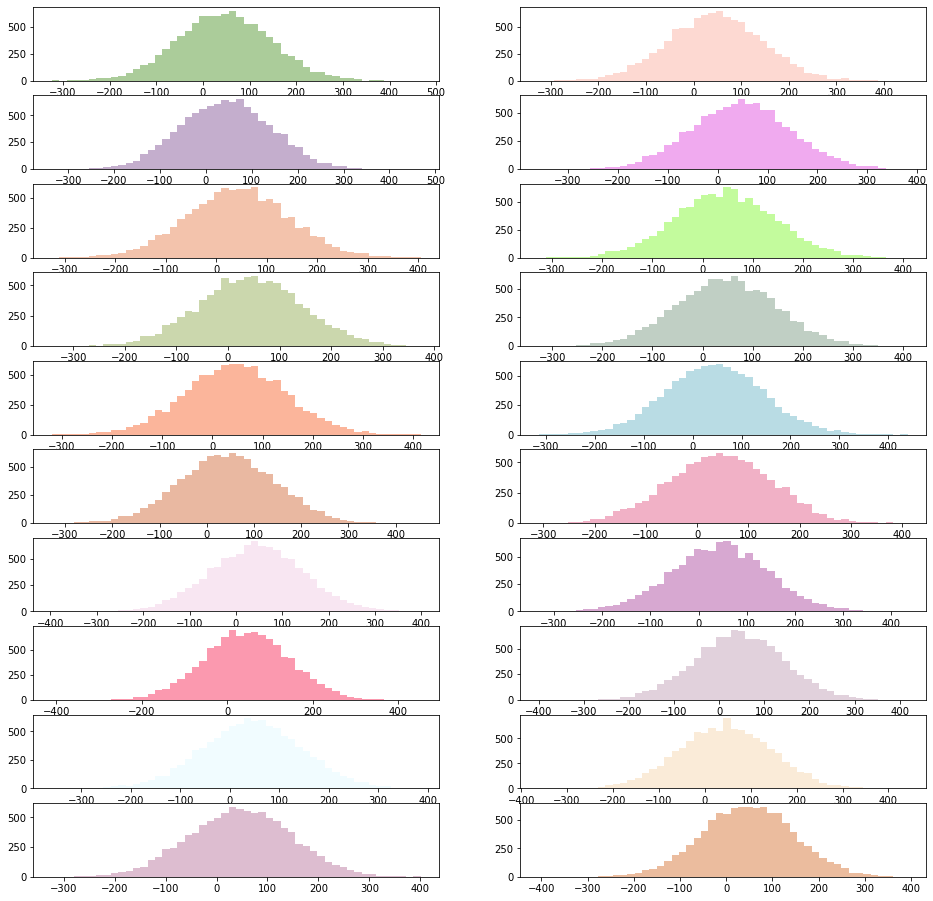

In [2]:
n = 20
mu = 45
sigma = 100
N = 10000

norm = stats.norm(loc=mu, scale=sigma)

gen = [norm.rvs(size=N) for i in range(n)]
    
fig = plt.subplots(20, 2, sharex=True, figsize=(16,16))

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]

for i in range(20):
    plt.subplot(10, 2, i+1)
    sns.distplot(gen[i], hist=True, kde=False, color=color[i])

plt.show()

Сравним попарно первые 4, 5, 10 и все 20 выборок между собой, без использования каких-либо поправок. Будем использовать t-критерий Стьюдента для независимых выборок, так как для каждого сравнения будем иметь по две независимые выборки непрерывных данных, нормально распределенных, с одинаковой дисперсией. Нулевая гипотеза всегда - выборки относятся к совокупности с одним средним, альтернативная гипотеза - выборки относятся к совокупностям с неравными средними.

In [3]:
def multiple_comparison(groups):
    accept = 0
    reject = 0
    
    for i,j in itertools.combinations(range(groups), 2):
        t, p = stats.ttest_ind(gen[i], gen[j])
        if p < 0.05:
            #print('Не можем принять нулевыю гипотезу о том, что выборки', i,'и', j,'относятся к совокупности с одним средним')
            #print('t-критерий =', t, '\np-value = ', p)
            reject += 1
            
        else:
            #print('Не можем отвергнуть нулевыю гипотезу о том, что выборки', i,'и', j,'относятся к совокупности с одним средним')
            #print('t-критерий =', t, '\np-value = ', p)
            accept += 1
        #print()
        
    print('Всего проведено', groups*(groups-1)/2, 'сравнений, из них t-тест верно определил, что выборки одинаковые, в', accept,'случаях и', reject,'раз(а) ошибся')

In [4]:
multiple_comparison(4)

Всего проведено 6.0 сравнений, из них t-тест верно определил, что выборки одинаковые, в 5 случаях и 1 раз(а) ошибся


In [5]:
multiple_comparison(5)

Всего проведено 10.0 сравнений, из них t-тест верно определил, что выборки одинаковые, в 6 случаях и 4 раз(а) ошибся


In [6]:
multiple_comparison(10)

Всего проведено 45.0 сравнений, из них t-тест верно определил, что выборки одинаковые, в 37 случаях и 8 раз(а) ошибся


In [7]:
multiple_comparison(20)

Всего проведено 190.0 сравнений, из них t-тест верно определил, что выборки одинаковые, в 169 случаях и 21 раз(а) ошибся


Сгенерируем теперь 16 выборок с неравными средними и сигмой между собой. 

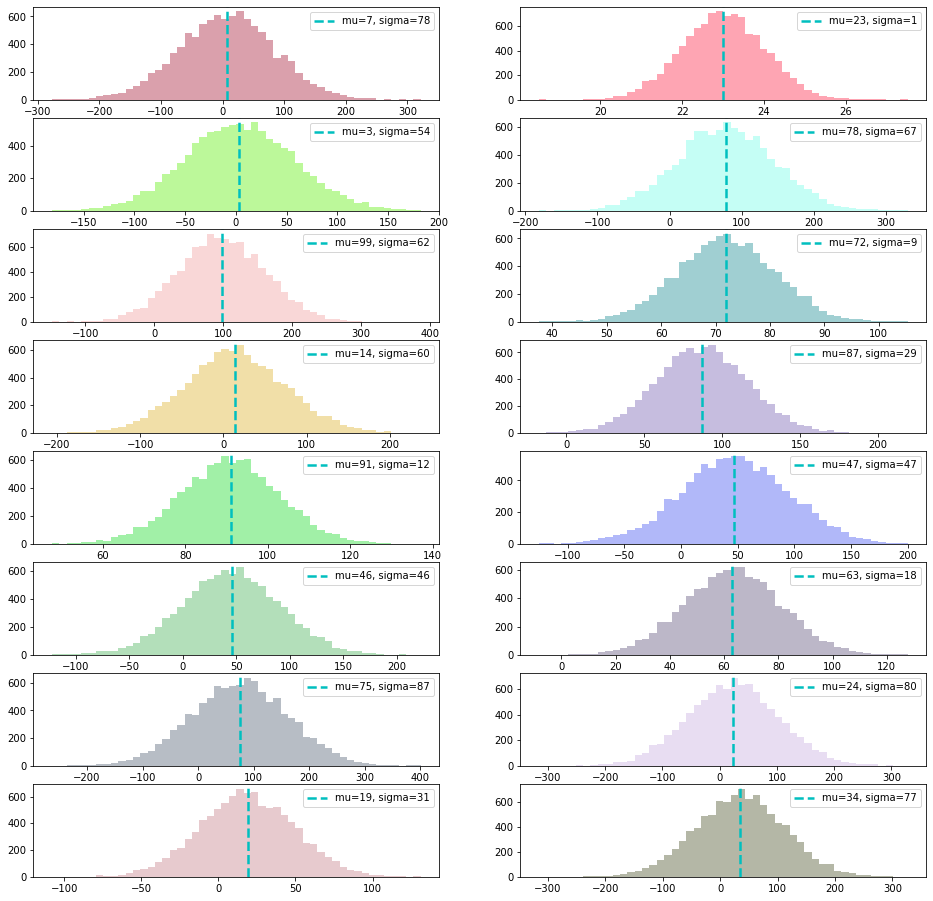

In [8]:
n = 16
mu = random.sample(range(100),n)
sigma = random.sample(range(100),n)
N = 10000

norm = [stats.norm(loc=mu[i], scale=sigma[i]) for i in range(n)]

gen = [norm[i].rvs(size=N) for i in range(n)]
   
fig = plt.subplots(8, 2, sharex=True, figsize=(16,16))

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]

for i in range(n):
    plt.subplot(8, 2, i+1)
    sns.distplot(gen[i], hist=True, kde=False, color=color[i])
    line = plt.axvline(mu[i], color='c', linestyle='dashed', linewidth=2.5)
    plt.legend(labels=['mu='+str(mu[i])+', sigma='+str(sigma[i])])
plt.show()

In [9]:
mu

[7, 23, 3, 78, 99, 72, 14, 87, 91, 47, 46, 63, 75, 24, 19, 34]

In [10]:
df = pd.DataFrame({
    'gen': [gen[i][j] for i in range(n) for j in range(N)],
    'label': [i+j-j for i in range(n) for j in range(N)]
})
df

,gen,label
0,-10.137925,0
1,164.871962,0
2,-221.303412,0
3,-69.854293,0
4,-120.980239,0
...,...,...
159995,91.345328,15
159996,91.499667,15
159997,57.993951,15
159998,141.382314,15


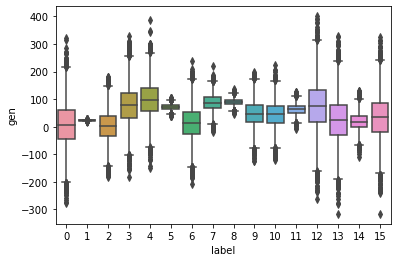

In [11]:
sns.boxplot(x=df["label"], y=df["gen"]);

Чтобы провести множественное сравнение полученных выборок, используя поправки Бонферрони и Холма-Бонферрони, воспользуемся встроенной библиотекой statsmodels.sandbox.stats.multicomp методом multipletests.

In [12]:
pvals = []

for i,j in itertools.combinations(range(n), 2):
        pvals.append(stats.ttest_ind(gen[i], gen[j])[1])

In [13]:
result = multipletests(pvals, alpha=0.05, method='bonferroni')

In [14]:
print('Всего проведено', n*(n-1)/2,'сравнений')
print('Из них', 120 - result[0].sum(), 'раз(a) тест не смог отвергнуть нулевую гипотезу о том, что выборки относятся к совокупности с одним средним,\nт.е. ошибся')

Всего проведено 120.0 сравнений
Из них 4 раз(a) тест не смог отвергнуть нулевую гипотезу о том, что выборки относятся к совокупности с одним средним,
т.е. ошибся


In [15]:
result = multipletests(pvals, alpha=0.05, method='holm')

print('Всего проведено', n*(n-1)/2,'сравнений')
print('Из них', 120 - result[0].sum(), 'раз(a) тест не смог отвергнуть нулевую гипотезу о том, что выборки относятся к совокупности с одним средним,\nт.е. ошибся')

Всего проведено 120.0 сравнений
Из них 1 раз(a) тест не смог отвергнуть нулевую гипотезу о том, что выборки относятся к совокупности с одним средним,
т.е. ошибся
